In [1]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона. done
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты. done
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

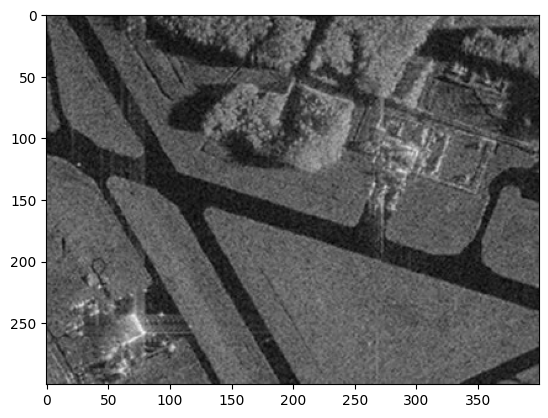

In [4]:
plt.imshow(image_gray, cmap="gray")

# Алгоритм разрастания регионов

Критерий однородности на основе среднего значения (представлен в примере)

In [5]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])

    if abs(av_val - img[point]) <= T:
        return True

    return False

Критерий однородности на основе медианы

In [6]:
def homo_median(img, mask, point, T):
    median = np.median(img[mask > 0])
    return abs(median - img[point]) <= T

In [7]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask

    return mask*255

Критерий однородности на основе среднего значения

In [8]:
seed_point = (100,100)
mask = region_growing(image_gray,seed_point,homo_average,7, 19)

192
340
391
485
576
780
881
847
1043
1239
1463
1497
1463
1762
1879
2012
1822
2026
2018
1440
1707
1377
1610
1434
1292
1409
1435
1537
1667
1956
2915
2569
1981
2312
2415
2531
3190
2402
2475
2399
2316
1628
668
612
519
381
160
55
0


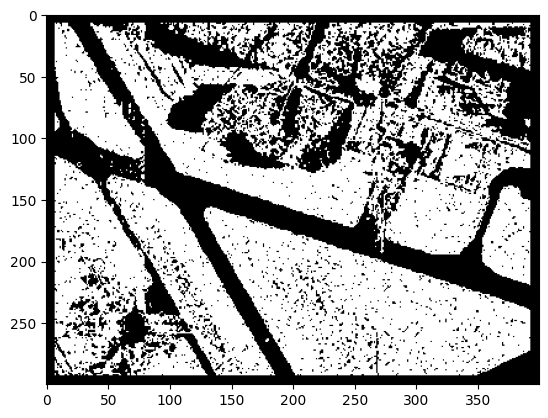

In [9]:
plt.imshow(mask, cmap="gray")

Критерий однородности на основе медианы

In [ ]:
mask2 = region_growing(image_gray,seed_point,homo_median,7, 19)
plt.imshow(mask2, cmap="gray")

192
343
394
493
566
784
888
856
1053
1255
1487
1520
1475
1784
1914
2039
1869
2263
1789
1755
1453
1525
1577
1394
1325
1881
1488
1595
1695
1996
2314
2600
1995
2332
2469
3185
2412


Сравнение

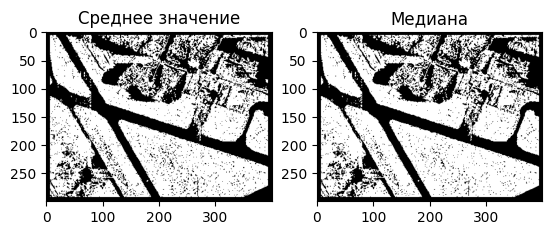

In [303]:
plt.subplot(1,2,1)
plt.imshow(mask, cmap="gray")
plt.title("Среднее значение")
plt.subplot(1,2,2)
plt.title("Медиана")
plt.imshow(mask2, cmap="gray")

# Watershed+Distance transform

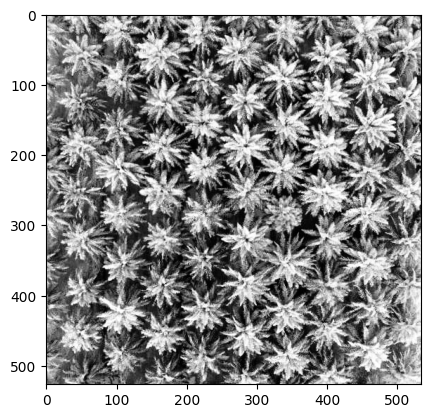

In [304]:
img = cv2.imread('palm_1.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.equalizeHist(img_gray)
plt.imshow(img_gray, cmap="gray")

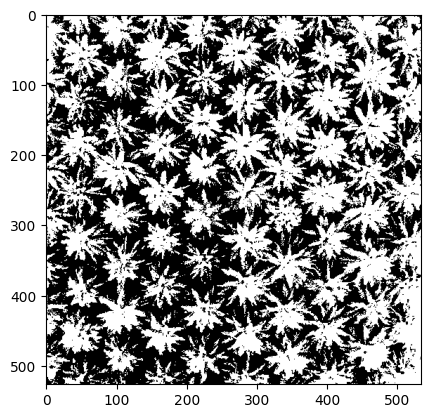

In [305]:
ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap="gray") #62 дерева

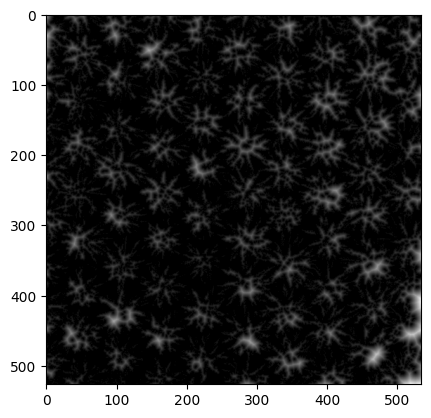

In [306]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
plt.imshow(dist, cmap="gray")

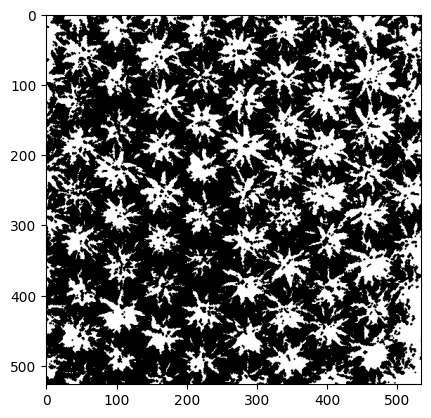

In [307]:
ret, sure_fg = cv2.threshold(dist, 0.07 * dist.max(), 255, cv2.THRESH_BINARY)
plt.imshow(sure_fg, cmap="gray")

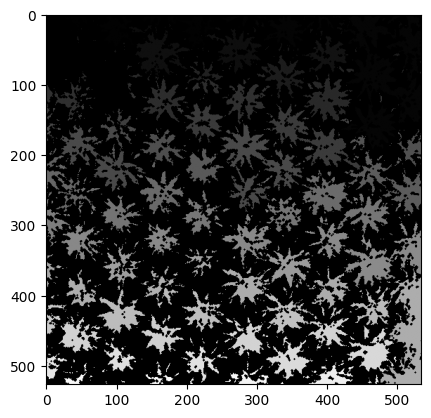

In [308]:
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers
#unknown = cv2.subtract(thresh, sure_fg)
#markers[unknown == 255] = 0
plt.imshow(markers, cmap="gray")

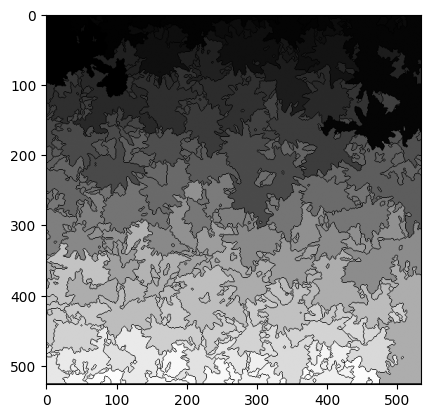

In [309]:
markers = markers.astype(np.int32)

markers_result = cv2.watershed(img, markers)
plt.imshow(markers_result, cmap="gray")

Функция для подсчета пальм

In [310]:
def analyze_watershed_result(markers_result, min_size=900):
    unique_markers = np.unique(markers_result) #всего маркеров
    object_markers = [m for m in unique_markers if m > 1]
    valid_objects = 0
    for marker in object_markers:
        object_mask = (markers_result == marker).astype(np.uint8) #маска для marker
        object_size = np.sum(object_mask) #площадь пальмы
        if object_size >= min_size:
            valid_objects += 1
    return valid_objects

Text(0.5, 1.0, '\nИТОГО: 75  пальм')

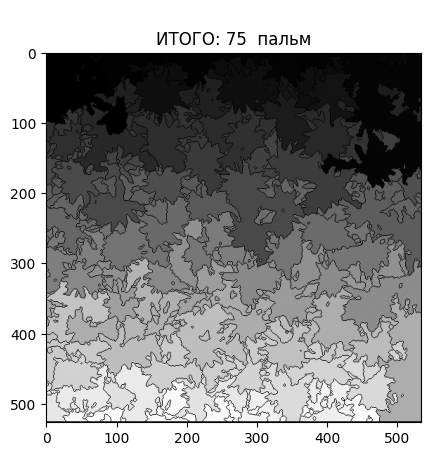

In [311]:
valid_palms = analyze_watershed_result(markers_result)
plt.imshow(markers_result, cmap="gray")
plt.title(f"\nИТОГО: {valid_palms}  пальм")